In [1]:
import streamlit as st
import jsonlines
import random
import pandas as pd
import json
import fileinput
import numpy as np
from pprint import pprint
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob
import re
import matplotlib.pyplot as plt


2022-05-29 19:06:31.383 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
#Importing Dataset
olafScholzJsonLines = jsonlines.open("OlafScholz.jl")

olafScholzTwitter = pd.read_json("OlafScholz.jl", lines = True)
print("Datensatzlänge: " + str(olafScholzTwitter.info()))

print(olafScholzTwitter.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   http_status   65 non-null     int64 
 1   account_name  65 non-null     object
 2   account_data  65 non-null     object
 3   params        65 non-null     object
 4   response      65 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.7+ KB
Datensatzlänge: None
   http_status account_name  \
0          200   OlafScholz   
1          200   OlafScholz   
2          200   OlafScholz   
3          200   OlafScholz   
4          200   OlafScholz   

                                        account_data  \
0  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
1  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
2  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
3  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
4  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   

         

In [3]:
"""
print("Response Metadaten: " + str(olafScholzTwitter["response"][0].keys()))
print(olafScholzTwitter["params"][0].keys())
for Key in ResponseKeys:
    print(type(olafScholzTwitter["response"][0][Key]))
    #print("{}-Metadaten: ".format(Key) + str(olafScholzTwitter["response"][0][Key]))
"""

'\nprint("Response Metadaten: " + str(olafScholzTwitter["response"][0].keys()))\nprint(olafScholzTwitter["params"][0].keys())\nfor Key in ResponseKeys:\n    print(type(olafScholzTwitter["response"][0][Key]))\n    #print("{}-Metadaten: ".format(Key) + str(olafScholzTwitter["response"][0][Key]))\n'

In [4]:
#print(olafScholzTwitter["response"][0].len)
#print("---")
#Starting to investigate Dataset
#print(olafScholzTwitter.describe())
#print(type(olafScholzTwitter))
#print(olafScholzTwitter.keys())
#for key in olafScholzTwitter:
#print("{} : {}".format(key, olafScholzTwitter[key]))
#print("{}".format(key) + str(type(olafScholzTwitter[key])))
    

In [5]:
"""
for line in olafScholzJsonLines:
    #print(line)
    
    keyResponse = line["response"]
    print("Response-Type:" + str(type(keyResponse)))
    print("Response-Keys:" + str(keyResponse.keys()))
    
    for key in keyResponse:
        print(type(keyResponse[key]))
        #pprint(keyResponse[key])
        #print("{}-Metadaten: ".format(key) + str(keyResponse[key].keys()))
    print("Includes-Metadaten: " + str(keyResponse["includes"].keys())+ "\n")
 
    print("Includes-Keys:" + str(keyResponse["includes"]["users"][0].keys())+"\n")
    #pprint("Example Includes:" +"\n" + str(keyResponse["includes"]["users"])+"\n")
        
    print("Meta-Metadaten: " + str(keyResponse["meta"].keys())+ "\n")
    data = keyResponse["data"]
    print("Type-Data: " + str(type(data))+ "\n")
    print(str(data[0]) + "\n")
    print("Type-Data[0]: " + str(type(data[0])) + "\n")
    print("data[0].keys(): " + str(data[0].keys()) + "\n")
    #print(dir(data[0].keys()))
    print("len(data[0].keys()): " + str(len(data[0].keys())) + "\n")
    break
"""

'\nfor line in olafScholzJsonLines:\n    #print(line)\n    \n    keyResponse = line["response"]\n    print("Response-Type:" + str(type(keyResponse)))\n    print("Response-Keys:" + str(keyResponse.keys()))\n    \n    for key in keyResponse:\n        print(type(keyResponse[key]))\n        #pprint(keyResponse[key])\n        #print("{}-Metadaten: ".format(key) + str(keyResponse[key].keys()))\n    print("Includes-Metadaten: " + str(keyResponse["includes"].keys())+ "\n")\n \n    print("Includes-Keys:" + str(keyResponse["includes"]["users"][0].keys())+"\n")\n    #pprint("Example Includes:" +"\n" + str(keyResponse["includes"]["users"])+"\n")\n        \n    print("Meta-Metadaten: " + str(keyResponse["meta"].keys())+ "\n")\n    data = keyResponse["data"]\n    print("Type-Data: " + str(type(data))+ "\n")\n    print(str(data[0]) + "\n")\n    print("Type-Data[0]: " + str(type(data[0])) + "\n")\n    print("data[0].keys(): " + str(data[0].keys()) + "\n")\n    #print(dir(data[0].keys()))\n    print("l

In [6]:
# Reply Dataframe
# Importing Data into final Dataframe for ML
replyDataFrame = pd.DataFrame(columns = ["target", "tweetid", "date", "time", "user", "text"])
print(replyDataFrame.head())
#dir(replyDataFrame)
iterator = 0

for line in olafScholzJsonLines:
    keyResponse = line["response"]
    data = keyResponse["data"]
    #print("Iterator {} has length: ".format(iterator) + str(len(data)))
    #pprint(data)
    #["target", "ids", "date", "flag", "user", "text"]
    newDataRow = [None, None, None, None, None, None]
    #print(line.keys())
    userName = line["account_name"]
    #print("User Name: " + str(line["account_name"])+"\n")
    newDataRow[4] = userName
    keyResponse = line["response"]
    data = keyResponse["data"]


    for tweet in data:
        #print("Tweet-ID: " + tweet["id"])
        #print(str(tweet) + "\n")
        tweetTarget = 1
       
        tweetID = tweet["id"]
        authorID = tweet["author_id"]
        tweetDate = tweet["created_at"][0:10]
        tweetTime = tweet["created_at"][11:19]
        #tweetFlag = "NO_QUERY"
        tweetText = tweet["text"]
        #tweetAuthor = tweet["context_annotations"]
        #tweetAuthor = tweet["context_annotations"]
        #tweetAuthor = userName
        #print(type(tweetAuthor))
        
        newDataRow[0] = tweetTarget
        newDataRow[1] = tweetID
        newDataRow[2] = tweetDate
        newDataRow[3] = tweetTime
        #newDataRow[4] = tweetFlag
        newDataRow[4] = authorID
        newDataRow[5] = tweetText
        #newDataRow[4] = tweetAuthor
        #pprint(newDataRow)
        replyDataFrame.loc[len(replyDataFrame)] = newDataRow
        #tempDataFrame = pd.DataFrame(newDataRow, columns["target", "ids", "date", "flag", "user", "text"])
        #replyDataFrame = replyDataFrame.append(tempDataFame, ignore_index = True)
        #replyDataFrame = replyDataFrame.append(pd.DataFrame(newDataRow, columns = ["target", "ids", "date", "flag", "user", "text"]),ignore_index = True)
        #break
    #print("{} Finale Dataframe \n".format(iterator) + str(replyDataFrame.head()))
    iterator += 1


Empty DataFrame
Columns: [target, tweetid, date, time, user, text]
Index: []


In [7]:
#print(dir(replyDataFrame))
print(len(replyDataFrame))
print(replyDataFrame.shape)
print(replyDataFrame.head())

6419
(6419, 6)
  target              tweetid        date      time      user  \
0      1  1515588838562971650  2022-04-17  07:11:52  38150247   
1      1  1514644785818058757  2022-04-14  16:40:32  38150247   
2      1  1514291545742184451  2022-04-13  17:16:53  38150247   
3      1  1514256817613905929  2022-04-13  14:58:53  38150247   
4      1  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...  
1  RT @Bundeskanzler: Meine Solidarität gilt @Kar...  
2  RT @Bundeskanzler: Sie haben Hilfe organisiert...  
3  RT @Bundeskanzler: Verantwortung übernehmen he...  
4  RT @Bundeskanzler: Die Sanktionen gegen #Russl...  


In [8]:
#print(replyDataFrame.query("date < '2022-01-01'").head())
#print(replyDataFrame.query("date < '2022-01-01'").count())
#print(replyDataFrame.query("text"[0:18] == "RT @Bundeskanzler:").head())
print("----")
#mask = replyDataFrame["text"].str.contains("RT @Bundeskanzler:").head()
#print(replyDataFrame[mask].head())
#print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].head())
#print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].count())
print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].sort_values("date",ascending = "true").head())
# -> Proven that first Retweet was after 2022-02-14

----
   target              tweetid        date      time      user  \
53      1  1493195813245313024  2022-02-14  12:09:58  38150247   
52      1  1493599012691365903  2022-02-15  14:52:09  38150247   
51      1  1493602211829587986  2022-02-15  15:04:51  38150247   
50      1  1494003008283287560  2022-02-16  17:37:29  38150247   
49      1  1494245849085493251  2022-02-17  09:42:26  38150247   

                                                 text  
53  RT @Bundeskanzler: Auf dem Weg in die #Ukraine...  
52  RT @Bundeskanzler: Der Frieden und die Sicherh...  
51  RT @Bundeskanzler: Ich habe Präsident #Putin i...  
50  RT @Bundeskanzler: Die #Corona-Regeln zeigen d...  
49  RT @Bundeskanzler: Gestern Abend habe ich mit ...  


In [9]:
#testing
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").head())
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").count())

0    True
1    True
2    True
3    True
4    True
Name: text, dtype: bool
6419


In [10]:
#cleansedTweetDF = replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:") or replyDataFrame["text"].str.contains("!RT @") ]
print("Size of dataframe :\n"+ str(replyDataFrame.count())+"\n----")
maskBundesKanz = replyDataFrame["text"].str.contains("RT @Bundeskanzler:")
maskNoRT = replyDataFrame["text"].str.contains("RT @")==False
print("Size of dataframe with RT @Bundeskanzler:\n" + str(replyDataFrame[maskBundesKanz].count())+"\n----")
print("Size of dataframe without RT @:\n" + str(replyDataFrame[maskNoRT].count())+"\n----")
#cleansedTweetDF contains all Tweets posted directly by Olaf before or after being Kanzler
cleansedTweetDF = replyDataFrame[maskBundesKanz | maskNoRT]
print("Size of cleansedTweetDF @:\n" + str(cleansedTweetDF.count())+"\n----")
print(cleansedTweetDF.head())
#cleansedTweetDF has "RT @Bundeskanzler:" still in the tweet. To not have any issues with ML we removed that part of the Tweet in the following parts

Size of dataframe :
target     6419
tweetid    6419
date       6419
time       6419
user       6419
text       6419
dtype: int64
----
Size of dataframe with RT @Bundeskanzler:
target     48
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
----
Size of dataframe without RT @:
target     4071
tweetid    4071
date       4071
time       4071
user       4071
text       4071
dtype: int64
----
Size of cleansedTweetDF @:
target     4119
tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
----
  target              tweetid        date      time      user  \
0      1  1515588838562971650  2022-04-17  07:11:52  38150247   
1      1  1514644785818058757  2022-04-14  16:40:32  38150247   
2      1  1514291545742184451  2022-04-13  17:16:53  38150247   
3      1  1514256817613905929  2022-04-13  14:58:53  38150247   
4      1  1513955069867274245  2022-04-12  18:59:51  38150247   

                                            

In [11]:
# Removing the Text \"RT @Bundeskanzler:\" from the text\n
print("ReplyDataframe: \n" + str(replyDataFrame[maskBundesKanz].count()))
cleansedAtBundKanzDF = replyDataFrame[maskBundesKanz].copy()
#print(str(cleansedAtBundKanzDF[\"text\"]))
cleansedAtBundKanzDF.text = cleansedAtBundKanzDF.text.str.strip("RT @Bundeskanzler: ")
print(cleansedAtBundKanzDF.head())
                                                                

ReplyDataframe: 
target     48
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
  target              tweetid        date      time      user  \
0      1  1515588838562971650  2022-04-17  07:11:52  38150247   
1      1  1514644785818058757  2022-04-14  16:40:32  38150247   
2      1  1514291545742184451  2022-04-13  17:16:53  38150247   
3      1  1514256817613905929  2022-04-13  14:58:53  38150247   
4      1  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [12]:
#appending the sliced versions to the Dataframe and resulting in the expected 4119 Tweets
cleansedTweetDFShort = replyDataFrame[maskNoRT].append(cleansedAtBundKanzDF)
print(cleansedTweetDFShort.count())
print(cleansedTweetDFShort.sort_values("date",ascending = False).head())

target     4119
tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
  target              tweetid        date      time      user  \
0      1  1515588838562971650  2022-04-17  07:11:52  38150247   
1      1  1514644785818058757  2022-04-14  16:40:32  38150247   
2      1  1514291545742184451  2022-04-13  17:16:53  38150247   
3      1  1514256817613905929  2022-04-13  14:58:53  38150247   
4      1  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [13]:
# Tobias und Thies 29.05.22

# Starting preparing for machine learning

# Making statement text in lower case

cleansedTweetDFShort

def clean(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'https?:\/\/S+', '', text) #Removes links
    
    return text

cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].apply(clean)

cleansedTweetDFShort

,target,tweetid,date,time,user,text
12,1,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...,...
49,1,1494245849085493251,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situatio...
50,1,1494003008283287560,2022-02-16,17:37:29,38150247,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1,1493602211829587986,2022-02-15,15:04:51,38150247,Ich habe Präsident Putin in Moskau verdeutlich...
52,1,1493599012691365903,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...


In [22]:
cleansedTweetDFShort = cleansedTweetDFShort.astype({'text':'string'})
print(cleansedTweetDFShort.dtypes)
cleansedTweetDFShort.head()

target     object
tweetid    object
date       object
time       object
user       object
text       string
dtype: object


,target,tweetid,date,time,user,text
12,1,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...


In [15]:
cleansedTweetDFShort10 = cleansedTweetDFShort[:10]
cleansedTweetDFShort10

,target,tweetid,date,time,user,text
12,1,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...,...
169,1,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jährt sich das Auffliegen des rechtsextr...
172,1,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank für das große Enga..."
174,1,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...
176,1,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank für die Einladung zum Kongress, u..."


In [16]:
#Get Polarity and Subjectivity

# Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
# The higher subjectivity means that the text contains personal opinion rather than factual information. 
# 0 means low personal opinion and 1 a lot of personal opinion

def getS (text):
    return TextBlob(text).sentiment.subjectivity

# Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.

def getP (text):
    return TextBlob(text).sentiment.polarity


cleansedTweetDFShort10['Personal Opinion (Subjectivity)'] = cleansedTweetDFShort10['text'].apply(getS)
cleansedTweetDFShort10['Sentiment (Polarity)'] = cleansedTweetDFShort10['text'].apply(getP)

cleansedTweetDFShort10

/var/folders/yl/dt_q929j1hg64nfh_lmhldhw0000gn/T/ipykernel_39387/2621984002.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleansedTweetDFShort10['Personal Opinion (Subjectivity)'] = cleansedTweetDFShort10['text'].apply(getS)
/var/folders/yl/dt_q929j1hg64nfh_lmhldhw0000gn/T/ipykernel_39387/2621984002.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleansedTweetDFShort10['Sentiment (Polarity)'] = cleansedTweetDFShort10['text'].apply(getP)


,target,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity)
12,1,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,0.00,0.6750
21,1,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,0.00,0.1750
54,1,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",0.00,0.2500
55,1,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,0.00,0.5000
56,1,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...,0.00,0.3500
...,...,...,...,...,...,...,...,...
169,1,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jährt sich das Auffliegen des rechtsextr...,0.00,-0.0375
172,1,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank für das große Enga...",0.25,0.1750
174,1,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...,0.20,0.0000
176,1,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank für die Einladung zum Kongress, u...",0.25,0.2500


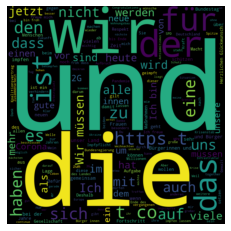

In [17]:
# plot Word Cloud

allWords = ' '.join([txt for txt in cleansedTweetDFShort10['text']])
wordCloud = WordCloud(width=1000, height = 1000, random_state = 30, max_font_size = 1000).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [18]:
# Create a function to compute analysis

def getA(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    elif 0.5 < score <= 1:
        return 'very positive'
    else:
        return 'positive'

cleansedTweetDFShort10['Analysis'] = cleansedTweetDFShort10['Sentiment (Polarity)'].apply(getA)
cleansedTweetDFShort10

/var/folders/yl/dt_q929j1hg64nfh_lmhldhw0000gn/T/ipykernel_39387/991973005.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleansedTweetDFShort10['Analysis'] = cleansedTweetDFShort10['Sentiment (Polarity)'].apply(getA)


,target,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
12,1,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,0.00,0.6750,very positive
21,1,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,0.00,0.1750,positive
54,1,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",0.00,0.2500,positive
55,1,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,0.00,0.5000,positive
56,1,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...,0.00,0.3500,positive
...,...,...,...,...,...,...,...,...,...
169,1,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jährt sich das Auffliegen des rechtsextr...,0.00,-0.0375,negative
172,1,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank für das große Enga...",0.25,0.1750,positive
174,1,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...,0.20,0.0000,neutral
176,1,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank für die Einladung zum Kongress, u...",0.25,0.2500,positive


In [25]:
# Print all positives


sortedDf = cleansedTweetDFShort10.sort_values(by=['Sentiment (Polarity)'])

sortedDf

for i in range (0, sortedDf.shape[0]):
    print("hi")

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [21]:
#Plot polarity and subjectivity

plt.figure(figsize=(8,6))

for i in range (0, sortedDf.shape[0]):
    plt.scatter(sortedDf['Sentiment (Polarity)'][i], sortedDf['Personal Opinion (Subjectivity)'][i], color='Green')
                
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

KeyError: 0

<Figure size 576x432 with 0 Axes>